In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

# 爬取的 URL 基础路径
base_url = 'https://www.wineenthusiast.com/search?q='

# 需要爬取的葡萄酒名称列表（数据集中的部分葡萄酒名称）
wine_titles = ["Vulkà Bianco", "Avidagos Red", "Pinot Gris"]

# 原始文件路径（会将新数据添加到这个文件中）
output_file = 'winemag-data-130k-v2.csv'

# 请求头，模拟浏览器请求
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

# 载入现有数据
data = pd.read_csv(output_file)

# 用于存储新爬取的数据
new_data = []

for title in wine_titles:
    # 编码URL查询参数
    url = f"{base_url}{title.replace(' ', '%20')}"
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')

    # 解析搜索结果页面中第一个葡萄酒链接（假设每个搜索只有一个结果）
    wine_link = soup.find('a', class_='product-title-link')
    if wine_link:
        wine_url = 'https://www.wineenthusiast.com' + wine_link.get('href')
        wine_response = requests.get(wine_url, headers=headers)
        wine_soup = BeautifulSoup(wine_response.text, 'html.parser')

        # 提取酒的信息
        wine_title = title
        wine_desc = wine_soup.find('div', class_='product-description').text.strip() if wine_soup.find('div', class_='product-description') else 'N/A'
        wine_price = wine_soup.find('span', class_='price').text.strip() if wine_soup.find('span', class_='price') else 'N/A'
        wine_country = wine_soup.find('span', class_='country').text.strip() if wine_soup.find('span', class_='country') else 'N/A'
        wine_points = wine_soup.find('span', class_='points').text.strip() if wine_soup.find('span', class_='points') else 'N/A'
        wine_variety = wine_soup.find('span', class_='variety').text.strip() if wine_soup.find('span', class_='variety') else 'N/A'
        wine_winery = wine_soup.find('span', class_='winery').text.strip() if wine_soup.find('span', class_='winery') else 'N/A'

        # 添加到新数据列表中
        new_data.append({
            'title': wine_title,
            'description': wine_desc,
            'price': wine_price,
            'country': wine_country,
            'points': wine_points,
            'variety': wine_variety,
            'winery': wine_winery
        })

        print(f"爬取完成: {wine_title}")
    else:
        print(f"未找到结果: {title}")

    # 等待一段时间以防止过多请求
    time.sleep(2)

# 将新数据转换为 DataFrame
new_data_df = pd.DataFrame(new_data)

# 将新数据追加到原始数据
data = pd.concat([data, new_data_df], ignore_index=True)

# 保存回 CSV 文件
data.to_csv(output_file, index=False)
print("数据已成功爬取并添加到文件中。")


In [ ]:
import pandas as pd

# Load the dataset to understand its structure
file_path = '/content/winemag-data-130k-v2.csv'
data = pd.read_csv(file_path)

# Display the first few rows and summary info to understand the dataset structure
data.head(), data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             129971 non-null  int64  
 1   country                129908 non-null  object 
 2   description            129971 non-null  object 
 3   designation            92506 non-null   object 
 4   points                 129971 non-null  int64  
 5   price                  120975 non-null  float64
 6   province               129908 non-null  object 
 7   region_1               108724 non-null  object 
 8   region_2               50511 non-null   object 
 9   taster_name            103727 non-null  object 
 10  taster_twitter_handle  98758 non-null   object 
 11  title                  129971 non-null  object 
 12  variety                129970 non-null  object 
 13  winery                 129971 non-null  object 
dtypes: float64(1), int64(2), object(11)


(   Unnamed: 0   country                                        description  \
 0           0     Italy  Aromas include tropical fruit, broom, brimston...   
 1           1  Portugal  This is ripe and fruity, a wine that is smooth...   
 2           2        US  Tart and snappy, the flavors of lime flesh and...   
 3           3        US  Pineapple rind, lemon pith and orange blossom ...   
 4           4        US  Much like the regular bottling from 2012, this...   
 
                           designation  points  price           province  \
 0                        Vulkà Bianco      87    NaN  Sicily & Sardinia   
 1                            Avidagos      87   15.0              Douro   
 2                                 NaN      87   14.0             Oregon   
 3                Reserve Late Harvest      87   13.0           Michigan   
 4  Vintner's Reserve Wild Child Block      87   65.0             Oregon   
 
               region_1           region_2         taster_name  \


In [ ]:
# Step 1: Drop the redundant 'Unnamed: 0' column
data_cleaned = data.drop(columns=['Unnamed: 0'])

# Step 2: Handle missing values
# Fill missing values in categorical columns with mode or specific value
data_cleaned['country'].fillna(data_cleaned['country'].mode()[0], inplace=True)
data_cleaned['province'].fillna(data_cleaned['province'].mode()[0], inplace=True)
data_cleaned['variety'].fillna(data_cleaned['variety'].mode()[0], inplace=True)

# For columns with significant missing values, replace NaNs with 'Unknown' where applicable
data_cleaned['designation'].fillna('Unknown', inplace=True)
data_cleaned['region_1'].fillna('Unknown', inplace=True)
data_cleaned['region_2'].fillna('Unknown', inplace=True)
data_cleaned['taster_name'].fillna('Unknown', inplace=True)
data_cleaned['taster_twitter_handle'].fillna('Unknown', inplace=True)

# Fill missing 'price' with the median value as it's a numerical feature
data_cleaned['price'].fillna(data_cleaned['price'].median(), inplace=True)

# Step 3: Check and drop duplicates
data_cleaned.drop_duplicates(inplace=True)

# Step 4: Summary of cleaned data for review
data_cleaned.info(), data_cleaned.head()

<ipython-input-6-57d23e1ba9f2>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_cleaned['country'].fillna(data_cleaned['country'].mode()[0], inplace=True)
<ipython-input-6-57d23e1ba9f2>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(va

<class 'pandas.core.frame.DataFrame'>
Index: 119988 entries, 0 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                119988 non-null  object 
 1   description            119988 non-null  object 
 2   designation            119988 non-null  object 
 3   points                 119988 non-null  int64  
 4   price                  119988 non-null  float64
 5   province               119988 non-null  object 
 6   region_1               119988 non-null  object 
 7   region_2               119988 non-null  object 
 8   taster_name            119988 non-null  object 
 9   taster_twitter_handle  119988 non-null  object 
 10  title                  119988 non-null  object 
 11  variety                119988 non-null  object 
 12  winery                 119988 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 12.8+ MB


(None,
     country                                        description  \
 0     Italy  Aromas include tropical fruit, broom, brimston...   
 1  Portugal  This is ripe and fruity, a wine that is smooth...   
 2        US  Tart and snappy, the flavors of lime flesh and...   
 3        US  Pineapple rind, lemon pith and orange blossom ...   
 4        US  Much like the regular bottling from 2012, this...   
 
                           designation  points  price           province  \
 0                        Vulkà Bianco      87   25.0  Sicily & Sardinia   
 1                            Avidagos      87   15.0              Douro   
 2                             Unknown      87   14.0             Oregon   
 3                Reserve Late Harvest      87   13.0           Michigan   
 4  Vintner's Reserve Wild Child Block      87   65.0             Oregon   
 
               region_1           region_2         taster_name  \
 0                 Etna            Unknown       Kerin O’Keefe   

In [ ]:
# Save the cleaned data to a new CSV file to share with the user
cleaned_file_path = '/winemag-data-130k-v2-cleaned.csv'
data_cleaned.to_csv(cleaned_file_path, index=False)
cleaned_file_path


'/winemag-data-130k-v2-cleaned.csv'

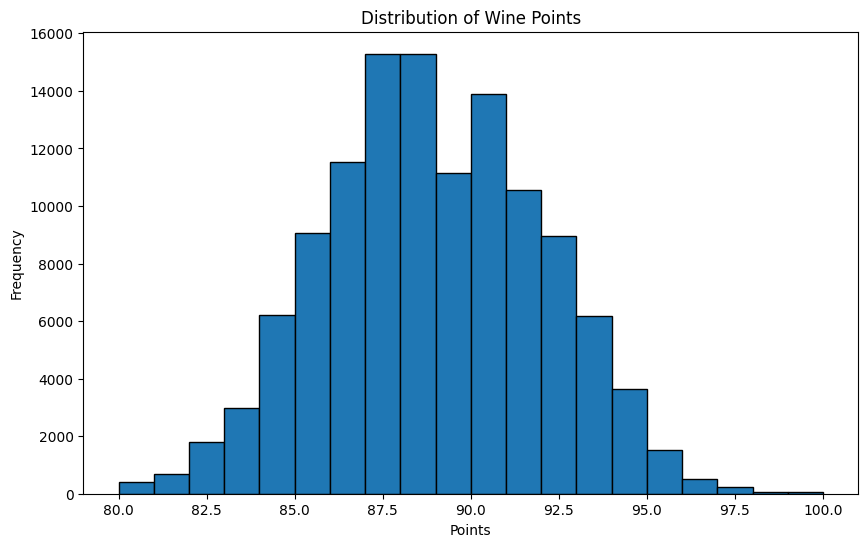

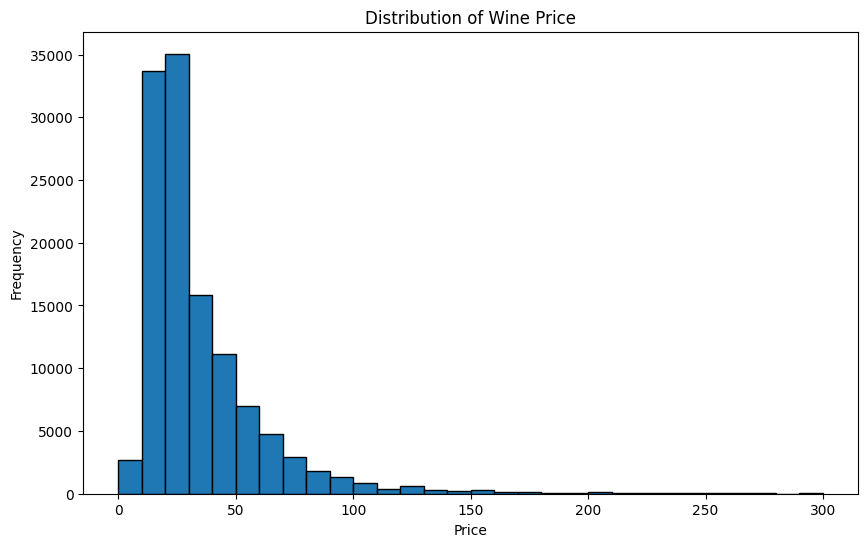

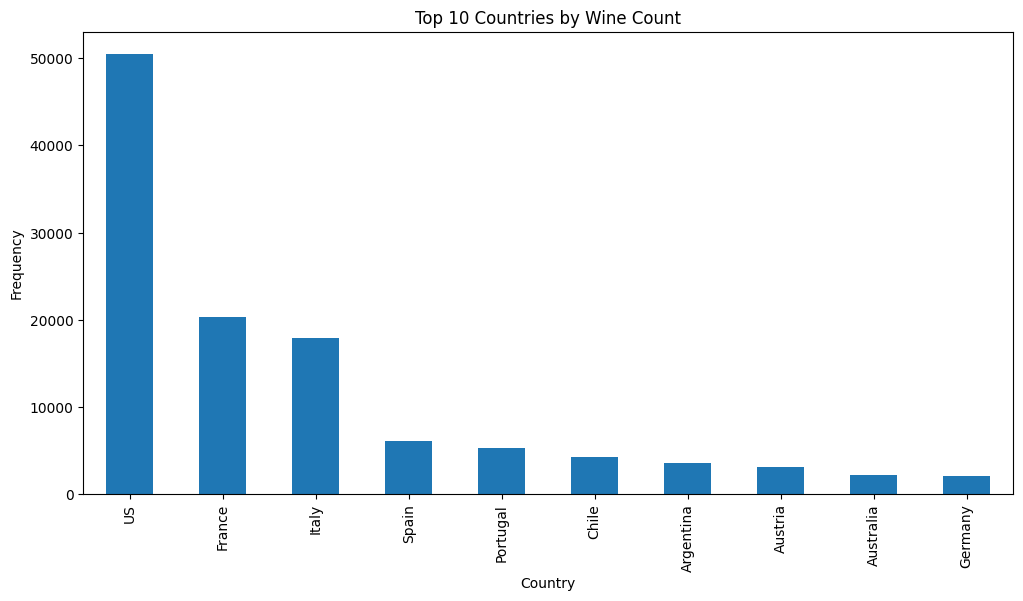

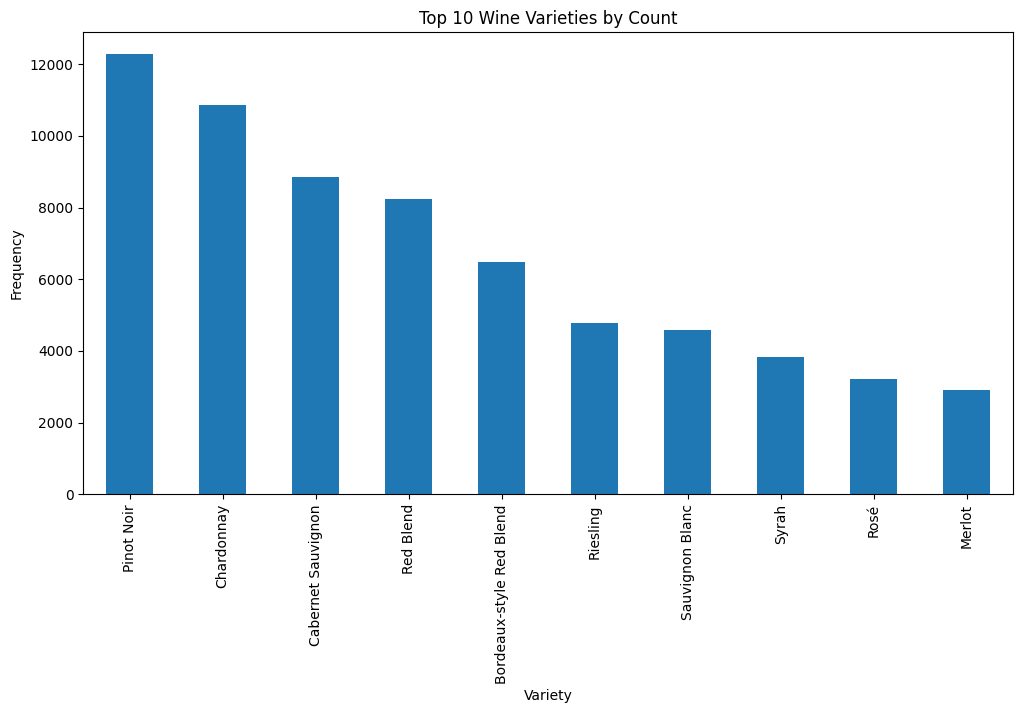

In [ ]:
import matplotlib.pyplot as plt

# Set up the figure size for better readability
plt.figure(figsize=(10, 6))

# Points distribution
plt.hist(data_cleaned['points'], bins=20, edgecolor='k')
plt.title('Distribution of Wine Points')
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.show()

# Price distribution
plt.figure(figsize=(10, 6))
plt.hist(data_cleaned['price'], bins=30, edgecolor='k', range=(0, 300))  # Limit range for better visualization
plt.title('Distribution of Wine Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# Country distribution (Top 10 countries)
plt.figure(figsize=(12, 6))
data_cleaned['country'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Countries by Wine Count')
plt.xlabel('Country')
plt.ylabel('Frequency')
plt.show()

# Variety distribution (Top 10 varieties)
plt.figure(figsize=(12, 6))
data_cleaned['variety'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Wine Varieties by Count')
plt.xlabel('Variety')
plt.ylabel('Frequency')
plt.show()
